In [1]:
import jax
import jax.numpy as jnp
import numpy as np
from jaxmao.layers import Conv2D, Dense, BatchNorm, ReLU, Flatten, StableSoftmax
from jaxmao.modules import Module
from jaxmao.optimizers import GradientDescent
from jaxmao.losses import CategoricalCrossEntropy
from jaxmao.metrics import Accuracy, Precision, Recall

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt

In [2]:
seed = 42
key = jax.random.PRNGKey(seed)

I0000 00:00:1697774799.887314   55696 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.


In [3]:
data = datasets.load_digits()
image, label = data['images'], data['target']

X_train, X_test, y_train, y_test = train_test_split(image, label, test_size=0.2, random_state=seed)

X_train = np.expand_dims(X_train, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)

enc = OneHotEncoder(sparse_output=False)
y_train_enc = enc.fit_transform(np.expand_dims(y_train, axis=1))
y_test_enc = enc.transform(np.expand_dims(y_test, axis=1))

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1437, 8, 8, 1), (360, 8, 8, 1), (1437,), (360,))

In [4]:
class DigitClassifier(Module):
    def __init__(self):
        super().__init__()
        self.add('conv1', Conv2D(1, 8, (3, 3), 1))
        self.add('bn1', BatchNorm(8, axis_mean=(0,1,2)))
        self.add('conv2', Conv2D(8, 2, (1, 1), 1))
        self.add('bn2', BatchNorm(2, axis_mean=(0,1,2)))
        self.add('flatten', Flatten())
        self.add('fc1', Dense(128, 64))
        self.add('bn3', BatchNorm(64))
        self.add('fc2', Dense(64, 10, activation=StableSoftmax()))

        self.add('relu', ReLU())
        
    def forward(self, params, x, state):
        x, state = self.apply(params, x, 'conv1', state)
        x, state = self.apply(params, x, 'bn1', state)
        x = ReLU()(x)
        x, state = self.apply(params, x, 'conv2', state)
        x, state = self.apply(params, x, 'bn2', state)
        x = ReLU()(x)
        x, state = self.apply(params, x, 'flatten', state)
        x, state = self.apply(params, x, 'fc1', state)
        x, state = self.apply(params, x, 'bn3', state)
        x = ReLU()(x)
        x, state = self.apply(params, x, 'fc2', state)
        return x, state

clf = DigitClassifier()
clf.init_params(key)
out, state = clf.pure_forward(clf.params, X_train[:200], clf.state)

summary = clf.summarize()

layer                output shape         #'s params          
conv1                (200, 8, 8, 8)       0                   
bn1                  (200, 8, 8, 8)       0                   
conv2                (200, 8, 8, 2)       0                   
bn2                  (200, 8, 8, 2)       0                   
flatten              (200, 128)           0                   
fc1                  (200, 64)            0                   
bn3                  (200, 64)            0                   
fc2                  (200, 10)            0                   



In [5]:
clf.state['bn1']['running_mean'].shape

(8,)

In [6]:
clf.params['bn1']['beta'].shape

(8,)

In [7]:
clf.forward = jax.jit(clf.forward)
clf.pure_forward = jax.jit(clf.pure_forward)

out, state = clf.pure_forward(clf.params, X_train[:200], clf.state)
out.shape, type(out), type(state)

((200, 10), jaxlib.xla_extension.ArrayImpl, dict)

In [8]:
from sklearn.utils import shuffle

criteria = CategoricalCrossEntropy()
criteria.calculate_loss = jax.jit(criteria.calculate_loss)
def loss_fn(model, params, x_true, y_true, state,
            criteria
            ):
    y_pred, new_state = model.pure_forward(params, x_true, state)
    loss = criteria(y_pred, y_true)
    return loss, new_state

val_grad_loss_fn = jax.value_and_grad(loss_fn, argnums=1, has_aux=True)
def training_loop(
    model, optimizer, x_true, y_true,
    epochs, lr=0.01, batch_size=16
):
    num_batch = len(x_true) // batch_size 
    for epoch in range(epochs):
        losses = 0.0
        x_true, y_true = shuffle(x_true, y_true)
        for n in range(num_batch):
            batch_x = x_true[n*batch_size:(n+1)*batch_size]
            batch_y = y_true[n*batch_size:(n+1)*batch_size]
            (loss, new_state), gradients = val_grad_loss_fn(model, model.params, 
                                                            batch_x, 
                                                            batch_y, 
                                                            model.state, 
                                                            criteria)
            losses = losses + loss
            model.params, optim_state = optimizer.step(model.params, gradients, lr=lr)
            model.update_state(new_state)
        
        accuracy = Accuracy()(model(model.params, batch_x), batch_y.argmax(axis=1))
        print('epoch {}: {}, {}'.format(epoch, losses/num_batch, accuracy))

In [9]:
optimizer = GradientDescent()
epochs = 1
lr = 0.01

training_loop(clf, 
              optimizer, 
              X_train, 
              y_train_enc, 
              epochs=epochs, lr=lr, batch_size=16
              )

epoch 0: 2.3247547149658203, 0.625


In [28]:
y_pred = clf(clf.params, X_test)

In [29]:
Accuracy()(y_pred, y_test)

Array(0.8666667, dtype=float32)

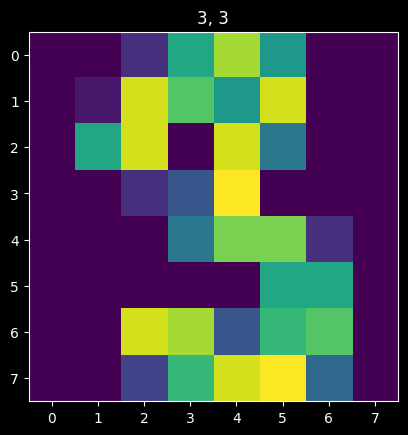

In [30]:
index = np.random.randint(0, len(X_test))
plt.imshow(X_test[index])
plt.title(f'{y_test[index]}, {y_pred[index].argmax()}')
plt.show()

# using .fit()!!!

In [31]:
clf = DigitClassifier()
clf.init_params(key)

out = clf(clf.params, X_test)
out.shape

(360, 10)

In [32]:
clf.layers['bn1'].shapes

{'gamma': (8,), 'beta': (8,)}

In [33]:
clf.layers['bn1'].params['gamma']

Array([1., 1., 1., 1., 1., 1., 1., 1.], dtype=float32)

In [34]:
clf.layers['bn1'].state['running_mean'][2]

Array(0., dtype=float32)

In [35]:
clf.compile(
    loss_fn=CategoricalCrossEntropy(),
    optimizer=GradientDescent(),
    metrics=[Accuracy(), Precision(), Recall()]
)

In [36]:
clf.fit(X_train, y_train_enc, lr=0.01, epochs=5)

epoch 0: Loss 2.6383633613586426; accuracy: 0.12713068181818182 precision: 0.6287878799167547 recall: 0.7159090909090909
epoch 1: Loss 1.9453428983688354; accuracy: 0.32457386363636365 precision: 0.7878787883303382 recall: 0.8181818181818182
epoch 2: Loss 1.5119731426239014; accuracy: 0.5205965909090909 precision: 0.9681818187236786 recall: 1.0
epoch 3: Loss 1.2567815780639648; accuracy: 0.6285511363636364 precision: 0.9545454545454546 recall: 0.9545454545454546
epoch 4: Loss 1.0962215662002563; accuracy: 0.7009943181818182 precision: 0.9772727272727273 recall: 0.9772727272727273
